In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
#tensorflow.contrib.rnn' has no attribute 'NASCell'
from tensorflow.contrib.rnn import GRUCell
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import *


import numpy as np
import random
import sys
import tensorlayer as tl
import tensorflow as tf
from bs4 import  BeautifulSoup

Using TensorFlow backend.


In [2]:
def read_clean_review(path):
    file = open(path, encoding='utf-8').read().lower()
    clean_1 = BeautifulSoup(file).get_text()
    clean_2 = clean_1.split('\n')
    clean = " ".join(clean_2)
    return clean

In [3]:
frn_full = read_clean_review("./frn.txt")
eng_full = read_clean_review("./eng.txt")


# 80 / 20 split for train and test
train_eng = eng_full[:-len(eng_full)//5]
train_frn = frn_full[:-len(frn_full)//5]

test_eng = eng_full[-len(eng_full)//5:]
test_frn = frn_full[-len(frn_full)//5:]
#k w z not in French

/home/janus/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/janus/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [4]:
# create char and index mapping
chars_full = []
chars_full += frn_full
chars_full += eng_full

chars = set(list(set(chars_full)))
chars.add('S') # S is start. 

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

#  
# Part I
#  

In [5]:
# get training data
def get_train(text, maxlen, seqlen = 0): # maxlen is real sequence length. If maxlen < seqlen, pad 0
    gaplen = seqlen - maxlen
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen):
        sentences.append("S"*gaplen + text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print('nb sequences:', len(sentences))
    
    print('Vectorization...')
    
    X = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

In [6]:
X_eng = []
y_eng = []
# after 5 iterations we get: [SSSSS, t], [SSSSt, r], [SSStr, u], [SStru, m], [Strum, p]
for i in np.arange(5):
    X, y = get_train(train_eng, i, 5)
    X_eng.append(X)
    y_eng.append(y)
    
# combine all shift data together
train_eng_X = np.concatenate(X_eng, axis=0)
train_eng_y = np.concatenate(y_eng, axis=0)

nb sequences: 8590
Vectorization...
nb sequences: 8589
Vectorization...
nb sequences: 8588
Vectorization...
nb sequences: 8587
Vectorization...
nb sequences: 8586
Vectorization...


In [7]:
X_frn = []
y_frn = []
for i in np.arange(5):
    X, y = get_train(train_frn, i, 5)
    X_frn.append(X)
    y_frn.append(y)
train_frn_X = np.concatenate(X_frn, axis=0)
train_frn_y = np.concatenate(y_frn, axis=0)

nb sequences: 9600
Vectorization...
nb sequences: 9599
Vectorization...
nb sequences: 9598
Vectorization...
nb sequences: 9597
Vectorization...
nb sequences: 9596
Vectorization...


In [8]:
# get test phrases
def sample_phrase(text, phrase_len, phrase_num):
    pos = np.random.choice(len(text)-phrase_len+1, phrase_num)
    phrases = []
    for i in range(phrase_num):
        phrases.append(text[pos[i]:pos[i]+phrase_len])
    return phrases
def phraseOnehot(phrases, shift, char_indices):
    code = np.zeros([len(phrases), len(phrases[0]), len(char_indices)], dtype=np.bool)
    #code = np.zeros([len(phrases), 5, len(char_indices)], dtype=np.bool)
    
    for i, phrase in enumerate(phrases):
        for s in range(shift):
            code[i, s, char_indices['S']] = 1
        for j, char in enumerate(phrase):
            if j + shift >= len(phrases[0]):
                break
            code[i, j+shift, char_indices[char]] = 1

    return code



test_eng_phrases = sample_phrase(test_eng, 5, 100)
test_frn_phrases = sample_phrase(test_frn, 5, 100)

# build Models

In [9]:
print('Build model...')

eng_model = Sequential()
eng_model.add(LSTM(128, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
1s - loss: 2.4922 - val_loss: 1.8647
Epoch 2/5
1s - loss: 2.2194 - val_loss: 1.6665
Epoch 3/5
1s - loss: 2.1383 - val_loss: 1.5605
Epoch 4/5
1s - loss: 2.0965 - val_loss: 1.4557
Epoch 5/5
1s - loss: 2.0649 - val_loss: 1.4276


In [10]:
print('Build model...')
frn_model = Sequential()
frn_model.add(LSTM(128, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 38392 samples, validate on 9598 samples
Epoch 1/5
2s - loss: 2.3828 - val_loss: 1.8228
Epoch 2/5
1s - loss: 2.1546 - val_loss: 1.6368
Epoch 3/5
1s - loss: 2.0878 - val_loss: 1.5363
Epoch 4/5
1s - loss: 2.0537 - val_loss: 1.4877
Epoch 5/5
1s - loss: 2.0288 - val_loss: 1.4463


# test score

In [11]:
def phrase_prob(phrase, model):
    logprob = np.zeros([len(phrase)])
    onehot = phraseOnehot(phrase, 0, char_indices)
    for shift in range(5,1,-1):
        phrase_shift = phraseOnehot(phrase, shift, char_indices)
        pred_prob = model.predict_proba(phrase_shift, verbose=0)
        logprob += np.log(pred_prob[onehot[:,5-shift,:]])
    return logprob


eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)


y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

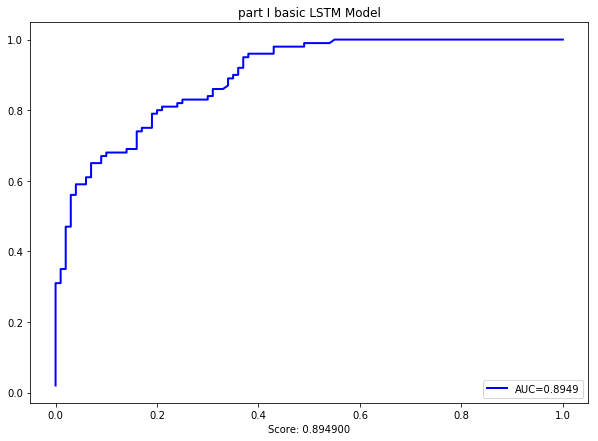

In [12]:
lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part I basic LSTM Model')
plt.show()

#  
# Part 2
#  

## 1. test different cell types

#### 1.1 GRU cell

In [13]:
print('Build model...')

eng_model = Sequential()
eng_model.add(GRU(128, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

print('Build model...')
frn_model = Sequential()
frn_model.add(GRU(128, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
1s - loss: 2.4203 - val_loss: 1.8633
Epoch 2/5
1s - loss: 2.2121 - val_loss: 1.6569
Epoch 3/5
1s - loss: 2.1482 - val_loss: 1.5616
Epoch 4/5
1s - loss: 2.1103 - val_loss: 1.5169
Epoch 5/5
1s - loss: 2.0816 - val_loss: 1.4848
Build model...
Train on 38392 samples, validate on 9598 samples
Epoch 1/5
1s - loss: 2.3280 - val_loss: 1.7610
Epoch 2/5
1s - loss: 2.1475 - val_loss: 1.6230
Epoch 3/5
1s - loss: 2.0959 - val_loss: 1.5919
Epoch 4/5
1s - loss: 2.0662 - val_loss: 1.5055
Epoch 5/5
2s - loss: 2.0433 - val_loss: 1.5248


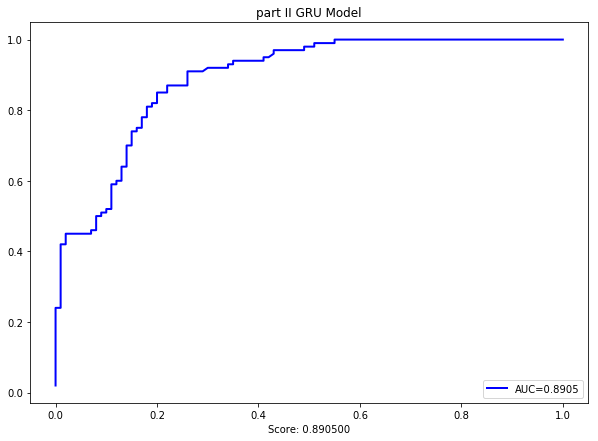

In [14]:
eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)

y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part II GRU Model')
plt.show()

#### 1.2 Basic RNN Cell

In [15]:
print('Build model...')

eng_model = Sequential()
eng_model.add(SimpleRNN(128, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

print('Build model...')
frn_model = Sequential()
frn_model.add(SimpleRNN(128, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
1s - loss: 2.8882 - val_loss: 2.2866
Epoch 2/5
0s - loss: 2.4067 - val_loss: 2.1610
Epoch 3/5
0s - loss: 2.3495 - val_loss: 2.0778
Epoch 4/5
0s - loss: 2.3019 - val_loss: 2.1210
Epoch 5/5
0s - loss: 2.2697 - val_loss: 1.8649
Build model...
Train on 38392 samples, validate on 9598 samples
Epoch 1/5
1s - loss: 2.9740 - val_loss: 2.2880
Epoch 2/5
0s - loss: 2.3933 - val_loss: 2.0904
Epoch 3/5
0s - loss: 2.2782 - val_loss: 1.9404
Epoch 4/5
1s - loss: 2.2395 - val_loss: 1.8582
Epoch 5/5
0s - loss: 2.2087 - val_loss: 1.8260


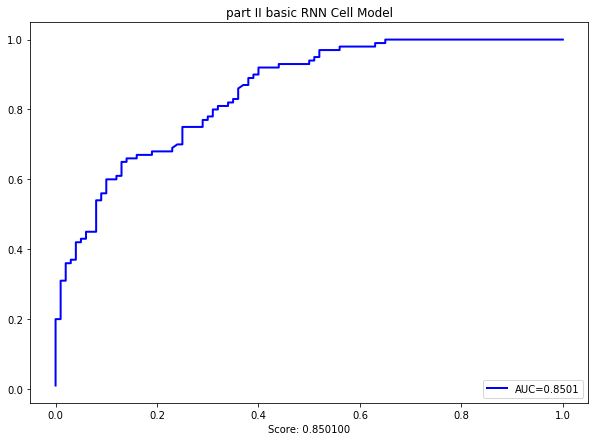

In [16]:
eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)

y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part II basic RNN Cell Model')
plt.show()

## 2.test different sizes 


#### 2.1 size = 256

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
2s - loss: 2.5259 - val_loss: 1.9431
Epoch 2/5
1s - loss: 2.2029 - val_loss: 1.6472
Epoch 3/5
1s - loss: 2.1248 - val_loss: 1.5004
Epoch 4/5
2s - loss: 2.0794 - val_loss: 1.4163
Epoch 5/5
1s - loss: 2.0514 - val_loss: 1.4326
Build model...
Train on 38392 samples, validate on 9598 samples
Epoch 1/5
2s - loss: 2.4493 - val_loss: 1.7645
Epoch 2/5
2s - loss: 2.1463 - val_loss: 1.5850
Epoch 3/5
2s - loss: 2.0783 - val_loss: 1.4704
Epoch 4/5
2s - loss: 2.0409 - val_loss: 1.4692
Epoch 5/5
1s - loss: 2.0171 - val_loss: 1.4227


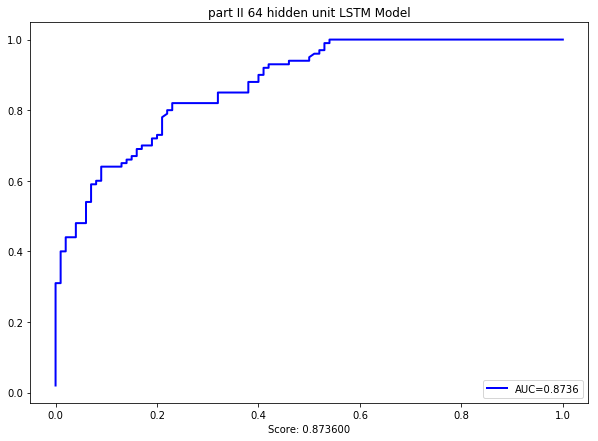

In [19]:
print('Build model...')

eng_model = Sequential()
eng_model.add(LSTM(256, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

print('Build model...')
frn_model = Sequential()
frn_model.add(LSTM(256, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)



eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)

y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part II 64 hidden unit LSTM Model')
plt.show()

#### 2.2 size = 64

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
2s - loss: 2.4908 - val_loss: 1.9336
Epoch 2/5
1s - loss: 2.2426 - val_loss: 1.7285
Epoch 3/5
2s - loss: 2.1663 - val_loss: 1.6335
Epoch 4/5
2s - loss: 2.1228 - val_loss: 1.5730
Epoch 5/5
1s - loss: 2.0911 - val_loss: 1.5176
Build model...
Train on 38392 samples, validate on 9598 samples
Epoch 1/5
2s - loss: 2.3994 - val_loss: 1.8748
Epoch 2/5
2s - loss: 2.1786 - val_loss: 1.7137
Epoch 3/5
2s - loss: 2.1132 - val_loss: 1.6120
Epoch 4/5
2s - loss: 2.0761 - val_loss: 1.5647
Epoch 5/5
2s - loss: 2.0513 - val_loss: 1.5131


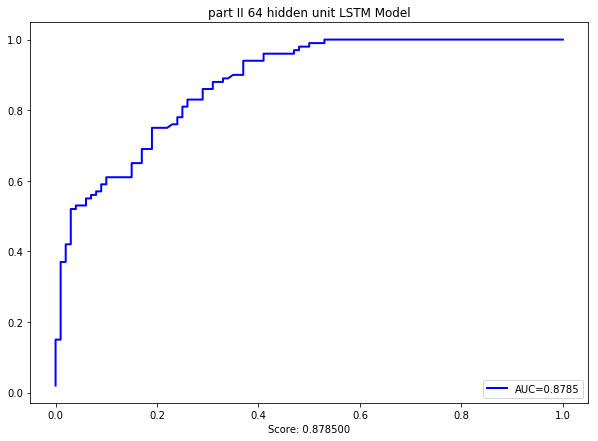

In [17]:
print('Build model...')

eng_model = Sequential()
eng_model.add(LSTM(64, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

print('Build model...')
frn_model = Sequential()
frn_model.add(LSTM(64, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)



eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)

y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part II 64 hidden unit LSTM Model')
plt.show()

#### 2.3 size = 32

Build model...


/home/janus/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34352 samples, validate on 8588 samples
Epoch 1/5
2s - loss: 2.5561 - val_loss: 2.0543
Epoch 2/5
2s - loss: 2.3031 - val_loss: 1.8528
Epoch 3/5
1s - loss: 2.2294 - val_loss: 1.7551
Epoch 4/5
1s - loss: 2.1842 - val_loss: 1.6963
Epoch 5/5
1s - loss: 2.1517 - val_loss: 1.6559
Build model...
Train on 38392 samples, validate on 9598 samples
Epoch 1/5
2s - loss: 2.4465 - val_loss: 1.9612
Epoch 2/5
1s - loss: 2.2192 - val_loss: 1.7968
Epoch 3/5
1s - loss: 2.1522 - val_loss: 1.7195
Epoch 4/5
1s - loss: 2.1154 - val_loss: 1.6483
Epoch 5/5
1s - loss: 2.0894 - val_loss: 1.6199


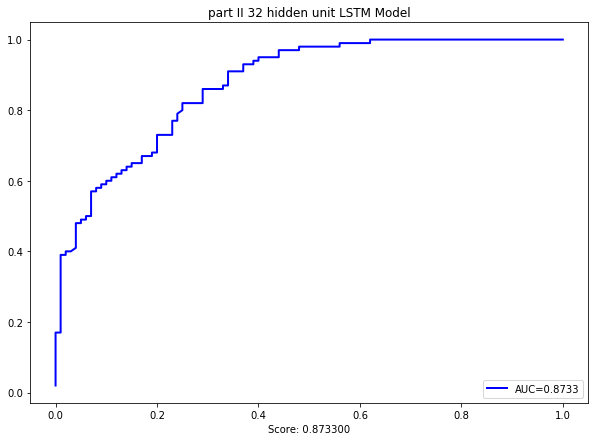

In [18]:
print('Build model...')

eng_model = Sequential()
eng_model.add(LSTM(32, input_shape=(5, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
eng_model.fit(train_eng_X, train_eng_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)

print('Build model...')
frn_model = Sequential()
frn_model.add(LSTM(32, input_shape=(5, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
frn_model.fit(train_frn_X, train_frn_y, verbose=2,
            batch_size=128, nb_epoch=5, validation_split=0.2)



eng_model_eng_prob = phrase_prob(test_eng_phrases, eng_model)
eng_model_frn_prob = phrase_prob(test_frn_phrases, eng_model)
frn_model_eng_prob = phrase_prob(test_eng_phrases, frn_model)
frn_model_frn_prob = phrase_prob(test_frn_phrases, frn_model)

y_hat = np.zeros(200)

y_hat[:100] = eng_model_eng_prob / frn_model_eng_prob
y_hat[100:] = eng_model_frn_prob / frn_model_frn_prob

y_true = np.ones(200)
y_true[:100] = 0

lw = 2
plt.figure(figsize=(10, 7))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, np.log(y_hat))
roc_auc= sklearn.metrics.auc(fpr, tpr)        

plt.plot(fpr, tpr, color='b', lw=lw, label='AUC=%.4f' % (roc_auc))
plt.legend(loc="lower right")
plt.xlabel("Score: %f"%roc_auc)
plt.title('part II 32 hidden unit LSTM Model')
plt.show()